## Part 1: Importing, Pre-processing, and Data inspection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2

df = pd.read_csv('data/titles.csv')

Create a bar plot to visualize the distribution of age certificates, including an indication for missing values.

In [43]:
import plotly.express as px

# Fill missing values and calculate value counts
target = df['age_certification'].fillna('Missing')
value_counts = target.value_counts().reset_index()
value_counts.columns = ['Age Certificates', 'Frequency']

# Create the bar plot
fig = px.bar(
    value_counts,
    x='Age Certificates',
    y='Frequency',
    title='Distribution of Age Certificates',
    labels={'Age Certificates': 'Age Certificates', 'Frequency': 'Frequency'},
    text='Frequency',
    color='Frequency',  # Add color based on frequency
    color_continuous_scale='Blues'  # Aesthetic color scheme
)

# Update layout for better appearance
fig.update_traces(
    textposition='auto',  # Display text inside or on bars
    marker_line_width=1.5,  # Add border to bars
    marker_line_color='black'  # Make borders stand out
)
fig.update_layout(
    title={'x': 0.5},  # Center the title
    xaxis_title='Age Certificates',
    yaxis_title='Frequency',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    template='plotly_white',  # Cleaner white theme
    margin=dict(t=50, l=50, r=50, b=50)  # Add spacing around the chart
)

# Show the interactive plot
fig.show()

 Impute  these missing values using the most common `age_certification` (mode) for each **genre**.(i.e., Calculate the most frequent `age_certification` value for each genre. Replace the missing values in the `age_certification` column with the mode of the corresponding genre.)

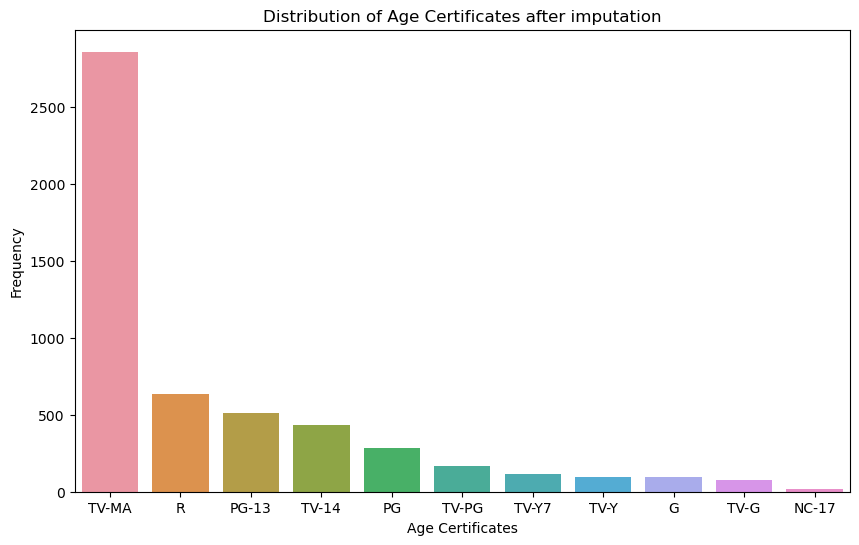

In [44]:
# Identify genre columns
genre_columns = [col for col in df.columns if col.startswith('genre_')]

# Compute the frequency of each age certification within each genre
def compute_genre_certification_ratios(df, genre_columns):
    ratio_dict = {}
    
    for genre in genre_columns:
        genre_df = df[df[genre] == 1]
        total_movies = len(genre_df[genre_df['age_certification'].notna()])
        certification_counts = genre_df['age_certification'].value_counts()
        
        certification_ratios = certification_counts / total_movies
        ratio_dict[genre] = certification_ratios
    return ratio_dict

# Compute the ratios for each genre
genre_certification_ratios = compute_genre_certification_ratios(df, genre_columns)

# Consider the frequency of each certification within each genre
def impute_age_certification_with_ratios(row, genre_columns, genre_certification_ratios):
    maximum_genre = {}
    max_value = {}

    if pd.isna(row['age_certification']):
        movie_genres = [genre for genre in genre_columns if row[genre] == 1]

        for genre in movie_genres:
            maximum_genre[genre] = genre_certification_ratios[genre].idxmax()
            max_value[genre] = genre_certification_ratios[genre].max()
        max_Series = pd.Series(max_value.values(), index=maximum_genre.values())
            
        return  max_Series.idxmax()  
    
    return row['age_certification']

# Apply the updated imputation function
df['age_certification'] = df.apply(impute_age_certification_with_ratios, axis=1, 
                                   args=(genre_columns, genre_certification_ratios))

# Visualize
target = df['age_certification']
order = target.value_counts().index
plt.figure(figsize=(10, 6))
sns.countplot(x=target, order=order)
plt.xlabel('Age Certificates')
plt.ylabel('Frequency')
plt.title('Distribution of Age Certificates after imputation')
plt.show()

#################
assert df.shape == (5277, 34)
assert df['age_certification'].isnull().sum() == 0


Use OneHotEncoder encoding method to transfer the `age_certification` feature to a series of binary features. (Transform it from a categorical feature to numeric)

In [45]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['age_certification']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df = pd.concat([df.drop(columns=['age_certification']), one_hot_df], axis=1)
###################

assert df.shape == (5277, 44)

Categorise the class vale of 'imdb_score' to 4 categories, as follows: **[0.5 marks]**
- 0: for imdb_score <= 5.5
- 1: for imdb_score > 5.5 and imdb_score <6.5
- 2: for imdb_score >= 6.5 and imdb_score <7.5
- 3: for imdb_score >= 7.5

Save the result in a new feature `imdb_category`. Replace the `imdb_score` with the `imdb_category` in the dataframe.

In [46]:
bins = [-float('inf'), 5.5, 6.5, 7.5, float('inf')]
labels = [0, 1, 2, 3]

# Use pd.cut to categorize the imdb_score
df['imdb_category'] = pd.cut(df['imdb_score'], bins=bins, labels=labels, right=False)

# Replace the imdb_score column with the imdb_category column
df= df.drop(columns=["imdb_score"])

#################

assert df.shape == (5277, 44)

## Part 2. Data Analysis [5 Marks]

In this section we will use some visualisation and statistical methods to better understand the dataset and do further data preprocessing if required.

##### ⭕️ Use a bar chart to visualise the frequency for the features `production_of_na`, `production_of_eu`, `production_of_ap` and `production_of_others` 

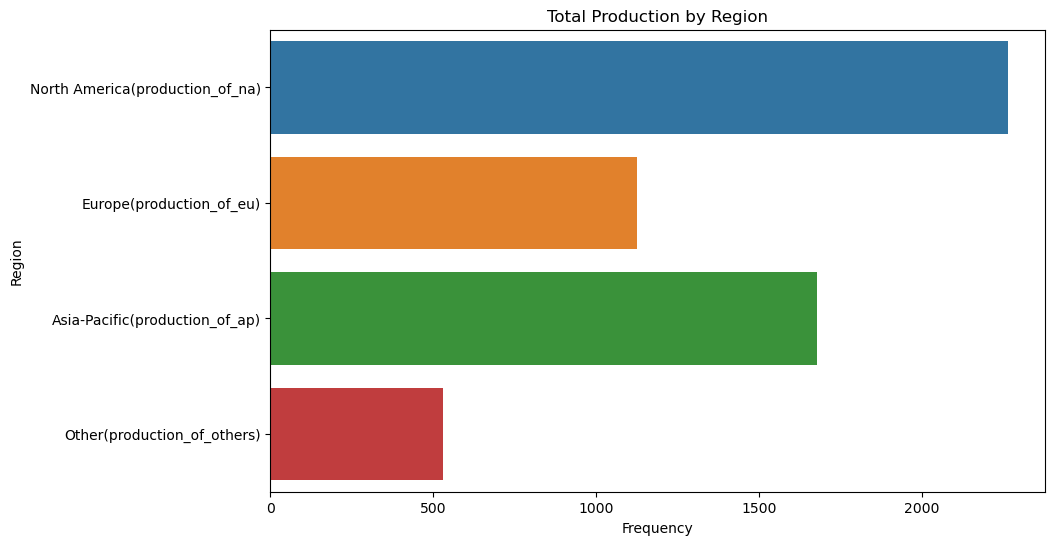

In [47]:
# Define a list of features to visualize
features = ['production_of_na','production_of_eu','production_of_ap','production_of_others']
titles = ['North America(production_of_na)', 'Europe(production_of_eu)', 'Asia-Pacific(production_of_ap)', 'Other(production_of_others)']

# dictionary to store the sum of each featur
data_sums = {title: df[df[feature] == 1][feature].sum() for feature, title in zip(features, titles)}
data_sums_df = pd.DataFrame(list(data_sums.items()), columns=['Region', 'Production'])


plt.figure(figsize=(10, 6))
sns.barplot(x='Production', y='Region', data=data_sums_df)
plt.xlabel('Frequency')
plt.ylabel('Region')
plt.title('Total Production by Region')
plt.show()
#################

The bar chart displays the frequency for the features production_of_na, production_of_eu, production_of_ap and production_of_others .
'North America(production_of_na)', 'Europe(production_of_eu)', 'Asia-Pacific(production_of_ap)', 'Other(production_of_others)']

- **North America(production_of_na)**: Has the highest frequency that is more than 2000, which is much higher than other
- **Asisa-Pacific and Europe**: Has a moderate level frequency, although asia-pacific is around 500 higher than Europe.
- **Other area**: Has the lowest frequency, which is around 500.


##### ⭕️ Use an appropriate visualisation to compare the changes in the number of MOVIES and SHOWS over the years. **[1 mark]**
- Identify in which year NETFLIX released the highest number of movies and which year released the highest number of shows. 

##### Viz 1: basic line chart

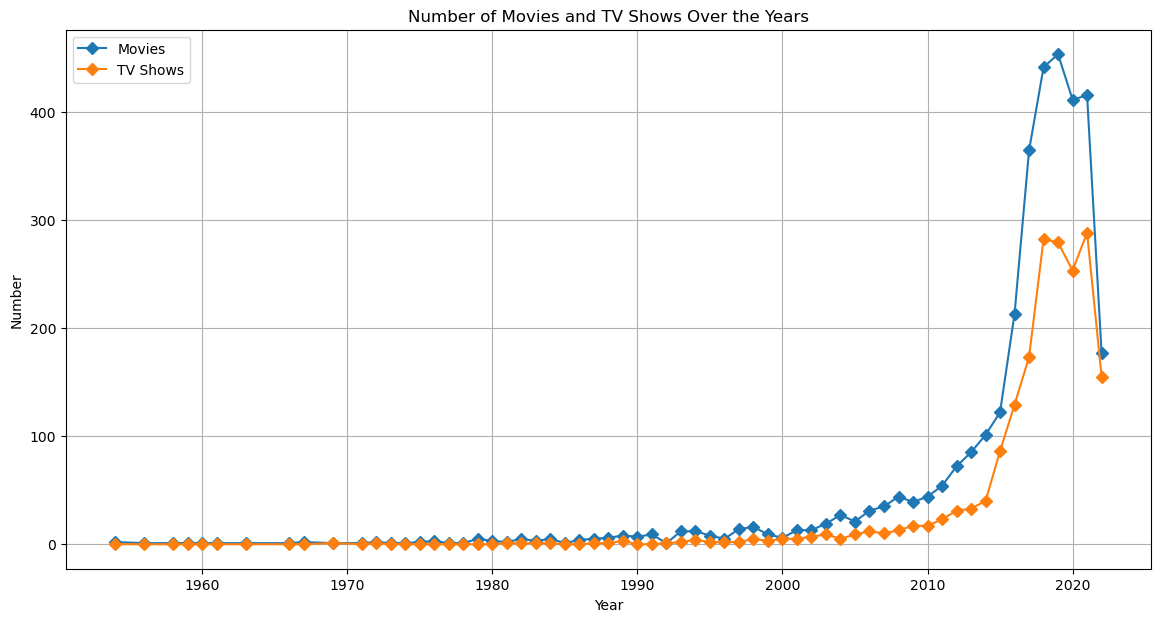

The year with the highest number of movies released by Netflix is 2019.
The year with the highest number of shows released by Netflix is 2021.


In [18]:
values = df['release_year'].unique()

#Function of finding the number of movie or show in specific year
def find_year_movie_or_shows(df, year, type):
    year_df = df[(df['release_year'] == year) & (df['type'] == type)]
    return year_df.shape[0] 

year_number_movie = {year: find_year_movie_or_shows(df, year, 0) 
                     for year in values}

year_number_shows = {year: find_year_movie_or_shows(df, year, 1) 
                     for year in values}

movie_data = pd.DataFrame(list(year_number_movie.items()), columns=['Year', 'Number of Movies'])
show_data = pd.DataFrame(list(year_number_shows.items()), columns=['Year', 'Number of Shows'])

# Find the maximum year
max_movies_year = max(year_number_movie, key=year_number_movie.get)
max_movies_number = year_number_movie[max_movies_year]
max_shows_year = max(year_number_shows, key=year_number_shows.get)
max_shows_number = year_number_shows[max_shows_year]

# Convert to dataframe
movie_data = pd.DataFrame(list(year_number_movie.items()), columns=['Year', 'Number of Movies'])
show_data = pd.DataFrame(list(year_number_shows.items()), columns=['Year', 'Number of Shows'])

# Sorting
movie_data = movie_data.sort_values('Year')
show_data = show_data.sort_values('Year')

#Ploting
plt.figure(figsize=(14, 7))
plt.plot(movie_data['Year'], movie_data['Number of Movies'], label='Movies', marker='D')
plt.plot(show_data['Year'], show_data['Number of Shows'], label='TV Shows', marker='D')
plt.xlabel('Year')
plt.ylabel('Number')
plt.title('Number of Movies and TV Shows Over the Years')
plt.legend()
plt.grid(True)
plt.show()

#################

# Output the year with the highest number of movies and shows
print(f"The year with the highest number of movies released by Netflix is {max_movies_year}.")
print(f"The year with the highest number of shows released by Netflix is {max_shows_year}.")


##### Viz 2: Intearctive and playable line chart over time

In [66]:
import pandas as pd
import plotly.graph_objects as go

# Assuming df is already available and processed
values = df['release_year'].unique()

def find_year_movie_or_shows(df, year, type):
    year_df = df[(df['release_year'] == year) & (df['type'] == type)]
    return year_df.shape[0] 

year_number_movie = {year: find_year_movie_or_shows(df, year, 0) for year in values}
year_number_shows = {year: find_year_movie_or_shows(df, year, 1) for year in values}

movie_data = pd.DataFrame(list(year_number_movie.items()), columns=['Year', 'Number of Movies'])
show_data = pd.DataFrame(list(year_number_shows.items()), columns=['Year', 'Number of Shows'])

movie_data = movie_data.sort_values('Year')
show_data = show_data.sort_values('Year')

# Create a Plotly figure
fig = go.Figure()

# Add traces for movies and shows
fig.add_trace(go.Scatter(x=movie_data['Year'], y=movie_data['Number of Movies'],
                         mode='lines+markers', name='Movies'))
fig.add_trace(go.Scatter(x=show_data['Year'], y=show_data['Number of Shows'],
                         mode='lines+markers', name='TV Shows'))

# Update layout for interactivity and aesthetics
fig.update_layout(
    title='Number of Movies and TV Shows Over the Years',
    xaxis_title='Year',
    yaxis_title='Number',
    legend=dict(x=0, y=1),
    updatemenus=[
        dict(
            type="buttons",
            showactive=True,
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[None, {
                         "frame": {"duration": 120, "redraw": True}, 
                         "fromcurrent": True, 
                         "transition": {"duration": 100}
                     }]),
                dict(label="Pause",
                     method="animate",
                     args=[[None], {
                         "frame": {"duration": 0, "redraw": False}, 
                         "mode": "immediate"
                     }])
            ],
            direction="left",
            pad={"r": 10, "t": 10},
           # showactive=True,
            x=0.85,
            xanchor="center",
            y=-0.2,
            yanchor="top"
        )
    ]
)

# Create animation frames
frames = []
for year in sorted(values):
    frames.append(go.Frame(
        data=[
            go.Scatter(
                x=movie_data['Year'][:year - movie_data['Year'].min() + 1],
                y=movie_data['Number of Movies'][:year - movie_data['Year'].min() + 1],
                mode='lines+markers',
                name='Movies',
                hovertemplate='In %{x}, there are %{y} movies.<extra></extra>'  # 显示完整句子
            ),
            go.Scatter(
                x=show_data['Year'][:year - show_data['Year'].min() + 1],
                y=show_data['Number of Shows'][:year - show_data['Year'].min() + 1],
                mode='lines+markers',
                name='TV Shows',
                hovertemplate='In %{x}, there are %{y} TV shows.<extra></extra>'  # 显示完整句子
            )
        ],
        name=str(year)
    ))

fig.frames = frames

# Show figure
fig.show()


##### Viz 3: Fancy one

/var/folders/m4/0sl37sl11v92vmkcj4prnqzm0000gn/T/ipykernel_15551/2329016864.py:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



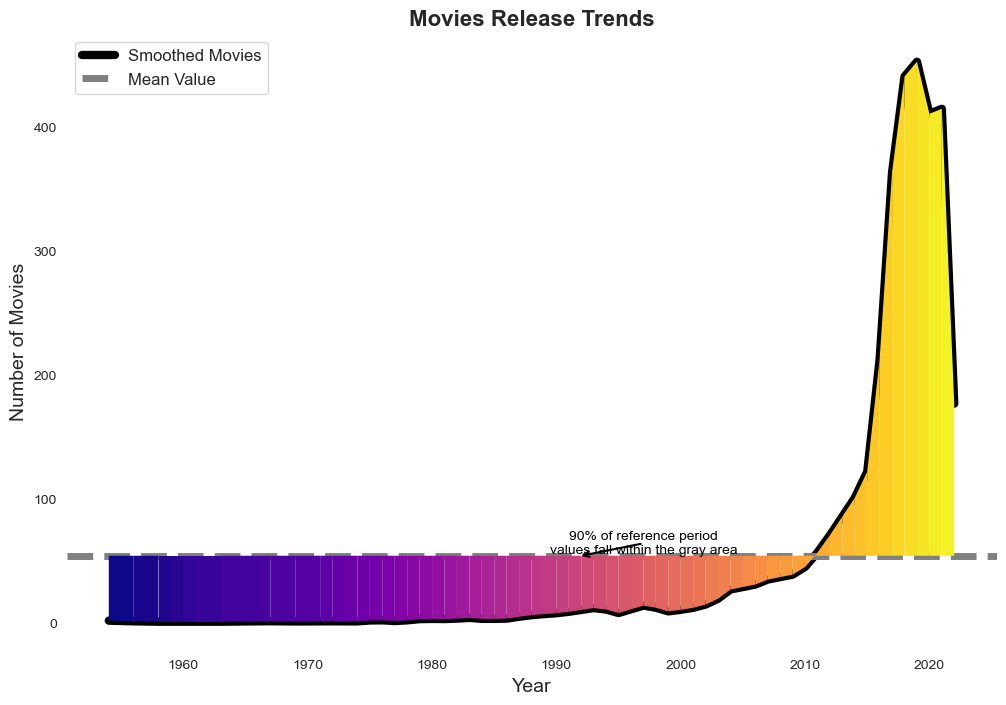

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.cm import get_cmap
import seaborn as sns

# Smooth the movie data using LOWESS
movie_data["Smoothed Movies"] = lowess(
    movie_data["Number of Movies"],  # Input data: Number of Movies
    movie_data["Year"],             # Input data: Year
    frac=1 / 12                     # Fraction of data to use for smoothing
)[:, 1]

# Calculate the difference between Number of Movies and its mean
movie_data["Movies-Mean"] = (
    movie_data["Number of Movies"] - movie_data["Number of Movies"].mean()
)

# Get a colormap for visualization
colormap = get_cmap("plasma")  # Use 'plasma' colormap
colors = colormap(np.linspace(0, 1, len(movie_data)))  # Map colors to data range

# Set Seaborn style for better aesthetics
sns.set_style("white")

# Create a plot figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot filled areas between smoothed curve and mean value
for i in range(len(movie_data) - 1):
    ax.fill_between(
        x=movie_data["Year"].iloc[i : i + 2],              # X-coordinates (Year)
        y1=movie_data["Smoothed Movies"].iloc[i : i + 2],  # Upper boundary (Smoothed)
        y2=movie_data["Number of Movies"].mean(),          # Lower boundary (Mean)
        color=colors[i],                                   # Fill color from colormap
        edgecolor="none",                                  # Remove edges
        zorder=8                                           # Layer order
    )

# Plot the smoothed movies curve
ax.plot(
    movie_data["Year"],                    # X-coordinates
    movie_data["Smoothed Movies"],         # Y-coordinates
    color="black",                         # Curve color
    linewidth=6,                           # Curve width
    label="Smoothed Movies"                # Label for legend
)

# Plot a horizontal line for the mean value
ax.axhline(
    y=movie_data["Number of Movies"].mean(),  # Y-coordinate for line
    color="gray",                             # Line color
    linestyle="--",                           # Line style (dashed)
    linewidth=5,                              # Line width
    label="Mean Value"                        # Label for legend
)

# Add legend and labels
ax.legend(loc="upper left", fontsize=12)   # Legend in the upper left corner
ax.set_title("Movies Release Trends", fontsize=16, fontweight="bold")  # Title
ax.set_xlabel("Year", fontsize=14)        # X-axis label
ax.set_ylabel("Number of Movies", fontsize=14)  # Y-axis label

# Remove grid lines for a clean look
ax.grid(False)

# Hide plot spines for a minimalist appearance
for spine in ax.spines.values():
    spine.set_visible(False)

# Add an annotation with an arrow pointing to the mean line
ax.annotate(
    "90% of reference period\nvalues fall within the gray area",  # Text for annotation
    xy=(movie_data["Year"].iloc[len(movie_data)//2], movie_data["Number of Movies"].mean()),
                    # Coordinates of the arrow tip (adjust later if needed)
    xytext=(movie_data["Year"].iloc[len(movie_data)//2] + 5, movie_data["Number of Movies"].mean() + 10)
,             # Position of the annotation text
    arrowprops={
        "arrowstyle": "->",       # Arrow style
        "color": "black",         # Arrow color
        "shrinkB": 0,             # Distance between arrow tip and target
        "lw": 1.5                 # Arrow line width
    },
    horizontalalignment="center", # Horizontal text alignment
    verticalalignment="center",   # Vertical text alignment
    color="black",                # Annotation text color
    fontsize=10,                  # Font size of annotation
    zorder=20                     # Annotation's layer order
)

# Show the plot
plt.draw()


**Q2.C)** Use a heatmap to visualize the relationship between all instances genres and their `imdb_category`. Ensure that each cell in the heatmap is labeled with the percentage of instances in each genre within each `imdb_category` (e.g. genre_action: 25% category_0, 25% category_1, 25% category_2, 25% category_3).  **[1 mark]**

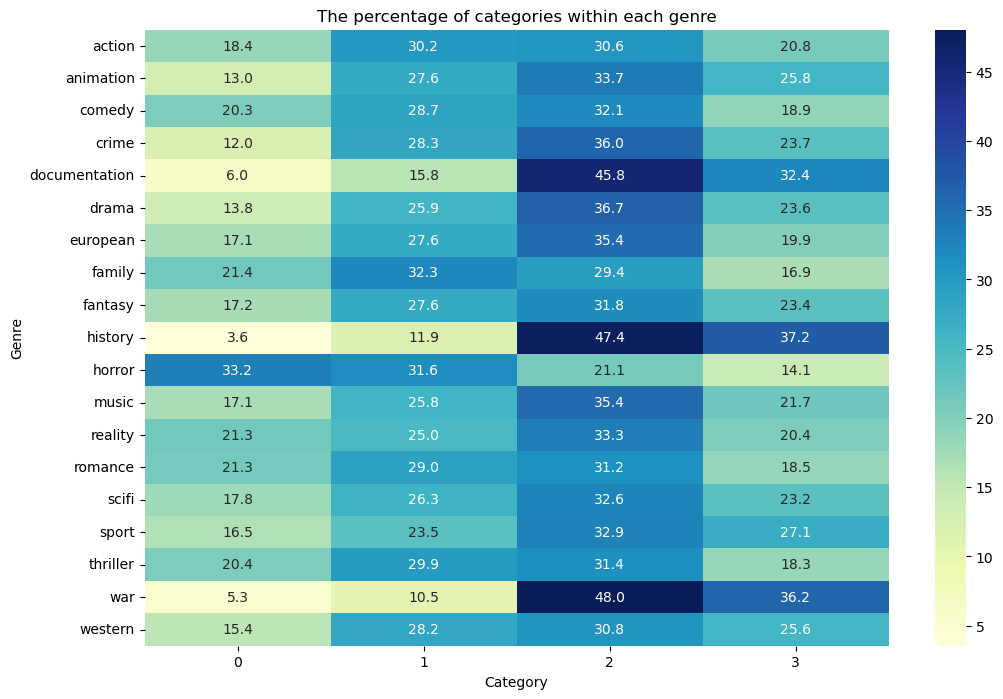

In [19]:
genres_columns = [col for col in df.columns if col.startswith('genre_')]
genres_columns.append('imdb_category')

df_genres = df[genres_columns].copy() 

# convert genre to Boolean
df_genres[genres_columns[:-1]] = df_genres[genres_columns[:-1]].astype(bool)

# Calculate total for imdb_category within each genre
genre_category_counts = df_genres.groupby('imdb_category').sum()

#  Calculate the total for each genre
genre_totals = df_genres[genres_columns[:-1]].sum()

# Calculate percentage
genre_percentages = genre_category_counts.div(genre_totals, axis=1) * 100

# Do traversal to plot
genre_percentages = genre_percentages.T

#ploting
genre_percentages.index = [col.replace('genre_', '') for col in genre_percentages.index]

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(genre_percentages, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('The percentage of categories within each genre')
plt.xlabel('Category')
plt.ylabel('Genre')
plt.show()
#################

**Q2.D)** Compare the distribution of IMDb categories between the genres 'history' and 'horror'. What patterns do you observe? **[0.5 marks]** In 2-3 sentences, explain your overall interpretation of how the genres correlate with the IMDb categories. **[0.5 marks]**

- The distribution of IMDb categories between the genres 'history' and 'horror'is visually reverse or they are conmplement (that is, when history is high, horror is low and vice versa; Horror likely receive lower IMDb ratings compared to history). 
- Among most genres, the majority of productions fall into categories 1 and 2 and overall, shows uneven distribution.
- Relatively few fall into categories 0 and 3, and category 3 takes higher proportion.
- Category 2 takes highest proportion.

## Question 3. Training and Tuning Decision Trees [2.5 marks]

In this part you are going to train and optimise a Decision Tree model to predict the `imdb_category` of the instances.

First you need to divide the `df` into 80% **train** (`train_df`) and 20% **test** (`test_df`) splits, using the stratification strategy. Set the `random_state` equal to `90049` and shuffle argument equal to `True`. 

In [20]:
from sklearn.model_selection import train_test_split

y = df['imdb_category']
train_df, test_df = train_test_split(df, test_size=0.2, stratify=y, random_state=90049, shuffle=True)
#################

**Q3.A)** Ignoring features `iid`, `title` and `description` use the `train_df` for training Decision Tree models with max_depth values of 5, 10, 30 and 40. For the decision tree set the random_state equal to `2024`. Report the most suitable max_value hyperparameter for your model using the accuracy results. **[1 mark]**

NOTE: You cannot use the `test_df` in this section to avoid any data leakage.

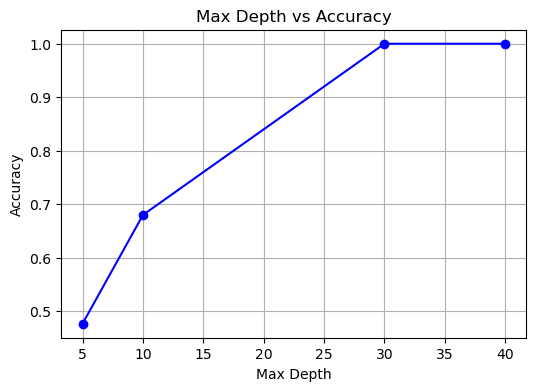

The best max_depth value for DT classifier for this dataset is 30


In [21]:
x_train_3a = train_df.drop(columns=['iid', 'title', 'description','imdb_category'])
y_train_3a = train_df['imdb_category']

# Set basic storage list
max_depth_value = [5,10,30,40]
best_max_depth_1 = 0
accuracy = 0
accuracy_scores = []

# Training and Evaluation
for max_depth in max_depth_value:
    n_clf = DecisionTreeClassifier(random_state=2024, max_depth=max_depth)
    n_clf.fit(x_train_3a, y_train_3a)
    n_clf_y_pred = n_clf.predict(x_train_3a)
    accuracy_x = accuracy_score(y_train_3a, n_clf_y_pred)
    # print(accuracy_x)
    accuracy_scores.append(accuracy_x)
    if accuracy_x > accuracy:
        accuracy = accuracy_x
        best_max_depth_1 = max_depth

# Ploting
plt.figure(figsize=(6, 4))
plt.plot(max_depth_value, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Max Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
#################
print("The best max_depth value for DT classifier for this dataset is", best_max_depth_1)

**Q3.B)** Split the `train_df` again into 80% **train** (`sub_train_df`) and 20% **optimisation** (`eval_df`) splits, using the stratification strategy. Set the random_state equal to `90049` and shuffle argument equal to `True`. 

Ignoring features `iid`, `title` and `description` use the `sub_train_df` for training Decision Tree models with max_depth values of 5, 10, 30 and 40. For the decision tree set the random_state equal to `2024`. Use the `eval_df` to find the most suitable value for the max_depth hyperparameter for your model. Report your selected max_depth value.  **[0.5 marks]**

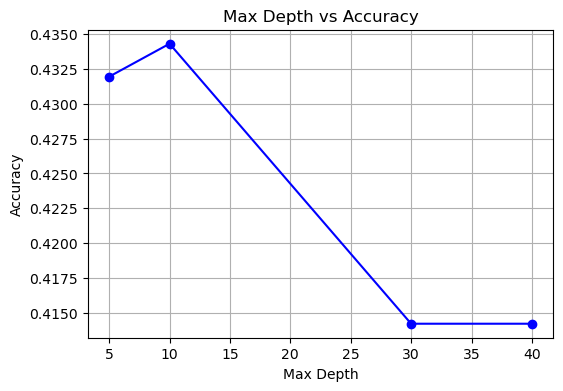

The best max_depth value for DT classifier for this dataset is 10


In [22]:
# Stratification again
new_y = train_df['imdb_category']
sub_train_df, eval_df = train_test_split(train_df, test_size=0.2, stratify=new_y, random_state=90049, shuffle=True)

# Prepare set
x_train_3b = sub_train_df.drop(columns=['iid', 'title', 'description','imdb_category'])
y_train_3b = sub_train_df['imdb_category']
x_eval_3b =eval_df.drop(columns=['iid', 'title', 'description','imdb_category'])
y_eval_3b = eval_df['imdb_category']

#set parameters
max_depth_value = [5,10,30,40]
best_max_depth_2 = 0
accuracy = 0
accuracy_scores = []

# Do training and evaluation
for max_depth in max_depth_value:
    n_clf = DecisionTreeClassifier(random_state=2024, max_depth=max_depth)
    n_clf.fit(x_train_3b, y_train_3b)
    n_clf_y_pred = n_clf.predict(x_eval_3b)
    accuracy_x = accuracy_score(y_eval_3b, n_clf_y_pred)
    # print(accuracy_x)
    accuracy_scores.append(accuracy_x)
    if accuracy_x > accuracy:
        accuracy = accuracy_x
        best_max_depth_2 = max_depth

#Ploting
plt.figure(figsize=(6, 4))
plt.plot(max_depth_value, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Max Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

#################

print("The best max_depth value for DT classifier for this dataset is", best_max_depth_2)

**Q3.C)** Compare the behaviour of the Decision Tree models with max_depth of 10 and 40 for the two models in Q3.B and Q3.A. Explain which max_depth value we should use as our hyperparameter in 1-2 sentences. Use your knowledge of the theoretical characteristics of DT and the used dataset to justify your observations. **[1 mark]**

- In 3A: model with depth 40 has better performance than that of model with 10
- In 3B: model with depth 10 has better performance than that of model with 40
- Should use a max_depth of 10: 
    - While 40 was identified as the optimal depth in scenario A, this choice is not good because testing model on the training set leads to data leakage (tests the model on known data) and big model also indicates poor generalizability. 
    - It is also because, in 3B, depth 40 too large that limit the generalizability of model (overfit); In contrast, 10 show good generalizability without overfit issues. 

## Question 4. Feature Selection [2.5 marks]

**Q4.A)** For the whole dataset (`df`) use the `CountVectorizer` class to separately convert features 'title' and 'description' text into a bag of words. This would increase the number of features dramatically. **[0.5 mark]**

In [23]:
# Initialization
vectorizer_title = CountVectorizer()
vectorizer_desc = CountVectorizer()

# fir and transform
title_bow = vectorizer_title.fit_transform(df['title'])
description_bow = vectorizer_desc.fit_transform(df['description'])

# transform to pd
title_bow_df = pd.DataFrame(title_bow.toarray(), 
                            columns=["title_" + word for word in 
                                     vectorizer_title.get_feature_names_out()])
desc_bow_df = pd.DataFrame(description_bow.toarray(), 
                           columns=["description_" + word for word in 
                                    vectorizer_desc.get_feature_names_out()])

# Combination and Formatting
df_with_bow = pd.concat([title_bow_df, desc_bow_df], axis=1)
vocabulary = df_with_bow.columns
title_bow_df.index = df.index  
desc_bow_df.index = df.index
df = pd.concat([df, title_bow_df, desc_bow_df], axis=1) 


# Print to check
print(f"Number of unique words (features) in the vocabulary: {len(vocabulary)}")
print(f"First 20 words in the vocabulary: {vocabulary[:20]}")

Number of unique words (features) in the vocabulary: 26571
First 20 words in the vocabulary: Index(['title_000', 'title_009', 'title_01', 'title_10', 'title_100',
       'title_1000', 'title_101', 'title_10½', 'title_11', 'title_11m',
       'title_12', 'title_122', 'title_13', 'title_137', 'title_13th',
       'title_14', 'title_15', 'title_16', 'title_18', 'title_19'],
      dtype='object')


**Q4.B)** Use **Chi Squared ($\chi^2$)** as the criterion for selecting the best 100 features among all the available features. **[0.5 mark]** 

*NOTE: This process can take a while depending on the processing power of your machine.*

In [24]:
## your code here
from sklearn.feature_selection import SelectKBest, chi2

x_4b = df.drop(['imdb_category', 'iid','title','description'], axis=1)
y_4b = df['imdb_category']

# # Selection
feature_selection = SelectKBest(chi2, k=100)
feature_selection.fit(x_4b, y_4b)
feature_indices = feature_selection.get_support(indices=True)  
selected_features = x_4b.columns[feature_indices]

#################
new_df = pd.concat([df[selected_features], df['imdb_category']], axis=1)
assert(new_df.shape == (5277, 101))

**Q4.C)** For another round of model tuning, divide the `new_df` to two parts 80% `train_new_df`, and 20% `test_new_df`. Use the stratification strategy. Set the `random_state` equal to `90049` and shuffle argument equal to `True`.  Then again divide the `train_new_df`into 80% `sub_train_new_df` and 20% `eval_new_df`. Use the stratification strategy. Set the `random_state` equal to `90049` and shuffle argument equal to `True`. 

Train and Tune Decision Tree models using the new datasets with max_depth values of 5, 10, 30 and 40. For the decision tree set the random_state equal to `2024`. Report the most suitable max_depth value for your model. **[0.5 marks]**

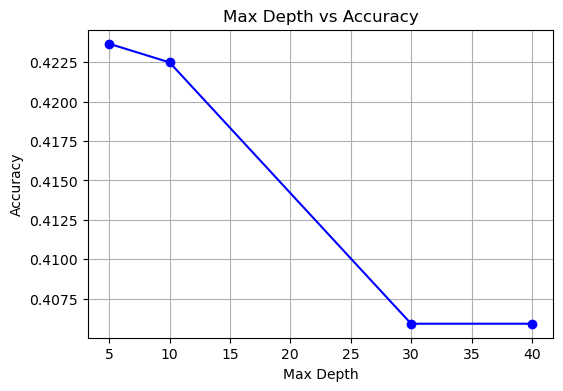

Best Max Depth: 5, Best Accuracy: 0.4236686390532544


In [25]:
train_new_df, test_new_df = train_test_split(new_df, test_size=0.2, stratify=new_df.iloc[:, -1], random_state=90049, shuffle=True)
sub_train_new_df, eval_new_df = train_test_split(train_new_df, test_size=0.2, stratify=train_new_df.iloc[:, -1], random_state=90049, shuffle=True)

# Prepare set
x_train_4c = sub_train_new_df.iloc[:, :-1].values  
y_train_4c = sub_train_new_df.iloc[:, -1].values  
x_eval_4c = eval_new_df.iloc[:, :-1].values
y_eval_4c = eval_new_df.iloc[:, -1].values

#set parameters
max_depth_value = [5,10,30,40]
best_max_depth_4c = 0
accuracy = 0
accuracy_scores = []

# Do training and evaluation
for max_depth in max_depth_value:
    n_clf_4c = DecisionTreeClassifier(random_state=2024, max_depth=max_depth)
    n_clf_4c.fit(x_train_4c, y_train_4c)
    n_clf_4c_y_pred = n_clf_4c.predict(x_eval_4c)
    accuracy_x = accuracy_score(y_eval_4c, n_clf_4c_y_pred)
    # print(accuracy_x)
    accuracy_scores.append(accuracy_x)
    if accuracy_x > accuracy:
        accuracy = accuracy_x
        best_max_depth_4c = max_depth

# Ploting
plt.figure(figsize=(6, 4))
plt.plot(max_depth_value, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Max Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(f"Best Max Depth: {best_max_depth_4c}, Best Accuracy: {accuracy}")
#################

**Q4.D)** Compare the behaviour of the Decision Tree models with max_depths of 10 and 40 for the two models in Q3.B and Q4.C. Justify any unexpected observation using your knowledge of the theoretical characteristics of Decision Trees and the used dataset. **[1 mark]**

- It is surprising that both model with depth 10 perform better than model with depth 40 (also has similar performance distribution across depth) [although model in Q4 has more information]. The potential reason can be:
    - Although dataset of Q4 contains more information, it should be useful to prediction otherwise. From our result, the overall similar performance (even a bit lower) to Q3 model maybe derived from these feature are relatively useless, which probably make model capture noises due to high dimensionality and tends to overfit. 
    - This is reasonable: very few words in text is usefull. For example, "Australia is a nice country", the most important part may be "Australia" and "nice". However, our dataset contain all tokens that can be extracted (even some meaningless token).

## Question 5. Evaluating Models

**Q5.A)**  Using `train_new_df` and `test_new_df` implement a Zero-R baseline for the dataset from Q4.B. Report the accuracy and visualise its confusion matrix. **[0.5 marks]**

0-R Model (Majority Class) Accuracy: 35.32%


/Users/toidi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/toidi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/toidi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



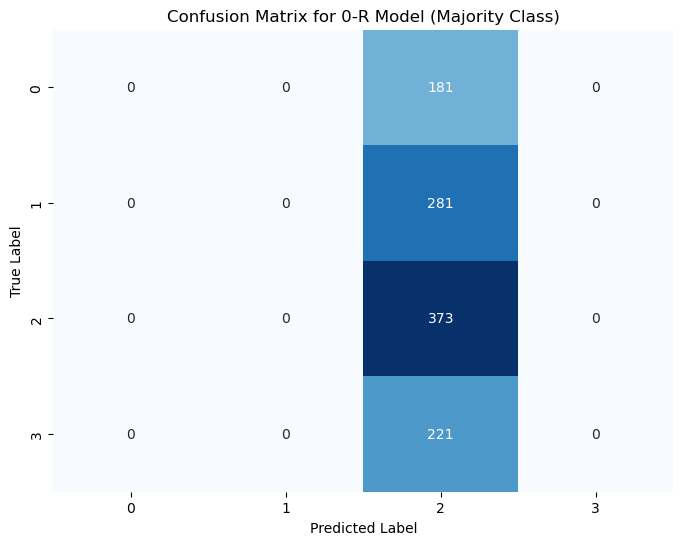

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# 0-R Model (Majority Class)
dummy_clf = DummyClassifier(strategy="most_frequent")

# Prepare set
x_train_5 = train_new_df.drop("imdb_category", axis=1)  
y_train_5 = train_new_df["imdb_category"]  
x_test_5 = test_new_df.drop("imdb_category", axis=1)  
y_test_5 = test_new_df["imdb_category"]  

dummy_clf.fit(x_train_5, y_train_5)
dummy_y_pred = dummy_clf.predict(x_test_5)
dummy_accuracy = accuracy_score(y_test_5, dummy_y_pred)
dummy_report = classification_report(y_test_5, dummy_y_pred)

#reporting and plotting
print("0-R Model (Majority Class) Accuracy: {:.2f}%".format(dummy_accuracy * 100))
cm = confusion_matrix(y_test_5, dummy_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for 0-R Model (Majority Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Q5.B)** Train and test a Multinomial Naive Bayes model using the `train_new_df` and `test_new_df` , visualize the Confusion Matrix. **[1 mark]**

0.23390151515151514


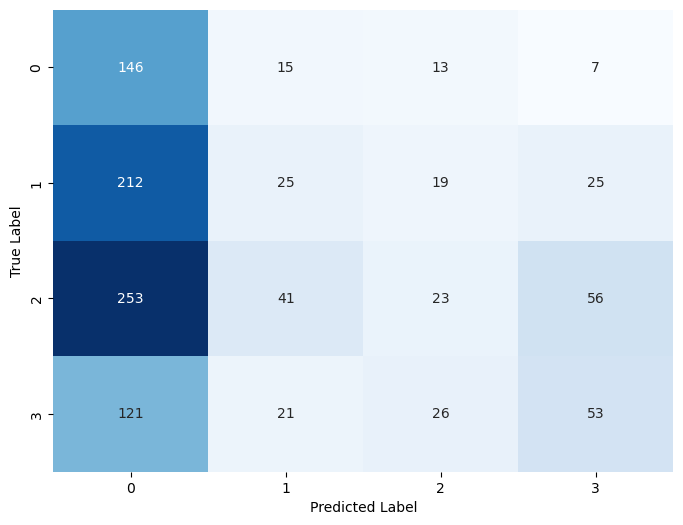

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

MNB_clf = MultinomialNB()
MNB_clf.fit(x_train_5, y_train_5)
y_pred_5b = MNB_clf.predict(x_test_5)
accuracy_5b = accuracy_score(y_test_5, y_pred_5b)

print(accuracy_5b)

cm = confusion_matrix(y_test_5, y_pred_5b, labels=MNB_clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
################

**Q5.C)** Compare the accuracy results and the confusion matrix for Q5.A and Q5.B. Explain your observations and justify the differences using your knowledge of the theoretical characteristics of these models and the used dataset. **[1 mark]** 

The accuracy of Multinomial Naive Bayes is about 10% less than that of Zero-R baseline.
because of a dataset imbalance, with about 35% belonging to class 2, aligning Zero-R's accuracy to 35%. 

- Zero-R baseline work well because it is use majority voting method and most of our data fall into label 2 (around 35%). This imbalance help model predict with accuracy around 35% as well.
- Multinomial Naive Bayes is designed based on multinomial distribution: n independent trials each of which leads to a k success. However, if we observe BoW, it contain mostly 0 and 1, which is closer to binary variable instead of have k potential values. Therefore, this contradictory leads to worse performance.

**Q5.D)** Train and test a Bernoulli Naive Bayes model using the `train_new_df` and `test_new_df` , visualize the Confusion Matrix. **[0.5 marks]**

0.3873106060606061


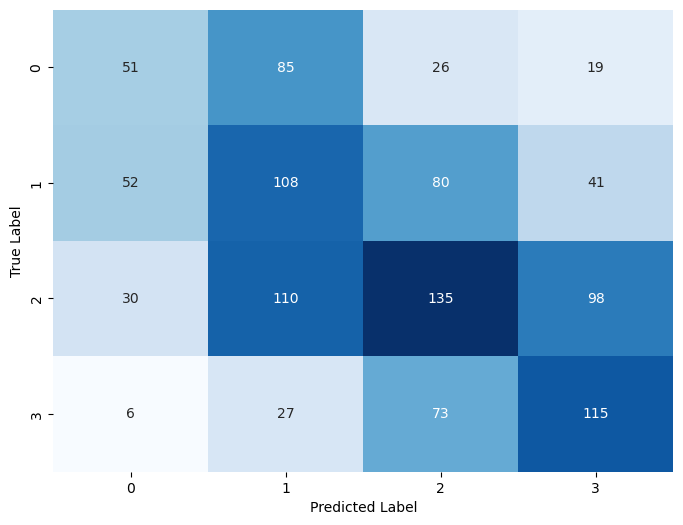

In [28]:
BNB_clf = BernoulliNB()
BNB_clf.fit(x_train_5, y_train_5)
y_pred_5d = BNB_clf.predict(x_test_5)
accuracy_5d = accuracy_score(y_test_5, y_pred_5d)
print(accuracy_5d)

cm = confusion_matrix(y_test_5, y_pred_5d, labels=MNB_clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

################

**Q5.E)** Compare the accuracy results and the confusion matrix for Q5.B and Q5.D. Explain your observations and justify the differences using your knowledge of the theoretical characteristics of these models and the used dataset. **[1 mark]** 

Bernoulli Naive Bayes outperforms Multinomial Naive Bayes by aboout 15%. This is because the predominant features (the token, most appear only once or do not appear in certain instance) are mostly showing binary pattern. This is closer to the Bernoulli distribution (binary variable) and thereby perform better.

**Q5.F)** For the decision tree tuned in part Q4.C, visualize two Confusion Matrices. One for the instances with the `production_of_ap` value not zero. And the other one for instances with the `production_of_others` value not zero. **[1 mark]** 

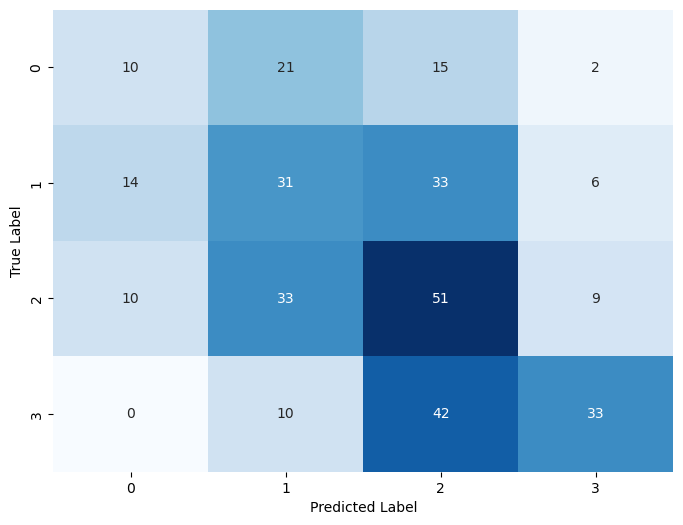

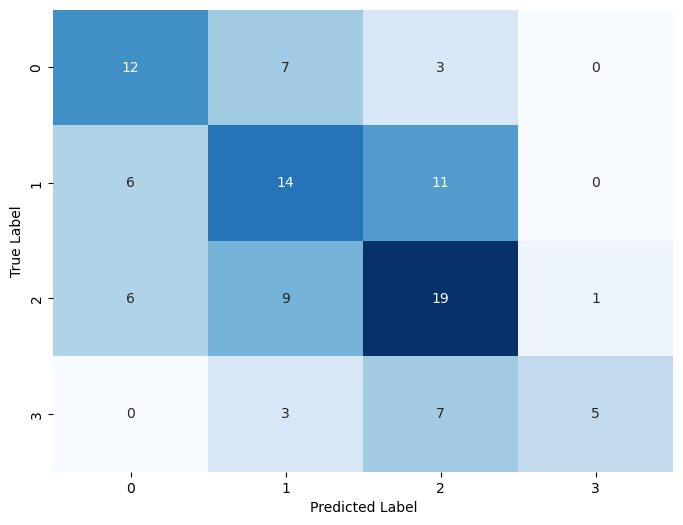

In [29]:
x_test_5_ap = x_test_5[x_test_5['production_of_ap'] != 0]  
y_test_5_ap = y_test_5[x_test_5['production_of_ap'] != 0]  

x_test_5_others = x_test_5[x_test_5['production_of_others'] != 0]  
y_test_5_others = y_test_5[x_test_5['production_of_others'] != 0] 

# Re-train as #174 mentioned in Ed
optimal_clf_5c = DecisionTreeClassifier(random_state=2024, max_depth=10)
optimal_clf_5c.fit(x_train_5, y_train_5)


# Generate Prediction
y_pred_ap = optimal_clf_5c.predict(x_test_5_ap)
y_pred_other = optimal_clf_5c.predict(x_test_5_others)

cm = confusion_matrix(y_test_5_ap, y_pred_ap, labels=MNB_clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

cm = confusion_matrix(y_test_5_others, y_pred_other, labels=MNB_clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

################

**Q5.G)** Compare your confusion maticies in Q5.F. Explain and justify the similarities and disparities, using your knowledge about the given dataset. **[1 mark]**

Similarity: Both models tend to predict the label as 2, even when they are wrong. This is because the majority of productions belong to this category. Both models show relatively good prediction accuracy, with some prediction errors close to the correct labels, indicating that these models has good predictability across different production areas.

Disparities: For titles produced in Asia-Pacific are more predicted as 1, 2, and 3; but in others are more predicted as 0, 1, and 2. This is because, in the training set, the data for two regions are more frequently labeled in these categories, reflecting the patterns of training data (somehow limits their generalibility for the label that did not appear frequently when training).